In [1]:
# -*- coding: utf-8 -*-
# This code is written in Python 3.7. To install the required packages, run the following commands:
# pip install pandas numpy matplotlib seaborn scikit-learn sympy
# This code is applicable to the Simargl 2022 dataset.
# implemented Adaptive Boosting (AdaBoost) algorithm for the Simargl 2022 dataset.


import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import LabelEncoder



/tmp/ipykernel_2505575/1933844634.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-03-05 14:04:26.502176: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-05 14:04:26.535990: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 14:

In [2]:
# Load the cleaned Simargl 2022 dataset
df = pd.read_csv(
    '/home/ibibers@ads.iu.edu/IDS_Datasets/Combined_datasets/Simargl_cleaned_dataset.csv')

tf.keras.backend.clear_session()

In [4]:
# Set the desired number of records for 'Normal' and 'Denial of Service' labels
desired_records_normal = 500000  # Change this to your desired number for 'Normal'
desired_records_dos = 3000000  # Change this to your desired number for 'Denial of Service'

# Filter data for 'Normal' and 'Denial of Service'
subset_df_normal = df[df['ALERT'] == 'Normal']
subset_df_dos = df[df['ALERT'] == 'Denial of Service']

# Sample the desired number of records from each class
subset_df_normal_sampled = subset_df_normal.sample(n=desired_records_normal, random_state=42)
subset_df_dos_sampled = subset_df_dos.sample(n=desired_records_dos, random_state=42)

# Combine the subsets with the rest of the data
final_subset = pd.concat([subset_df_normal_sampled, subset_df_dos_sampled, df[df['ALERT'] != 'Normal'][df['ALERT'] != 'Denial of Service']])

# Optional: Shuffle the final subset
final_subset = final_subset.sample(frac=1, random_state=42)


/tmp/ipykernel_2505575/364247859.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  final_subset = pd.concat([subset_df_normal_sampled, subset_df_dos_sampled, df[df['ALERT'] != 'Normal'][df['ALERT'] != 'Denial of Service']])


In [5]:
dropped_df = ['ALERT']
X = final_subset.drop(dropped_df, axis=1)
y = final_subset['ALERT']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Initial train test split set and split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(final_subset['ALERT'].value_counts())

ALERT
Port Scanning        4170194
Denial of Service    3000000
Normal                500000
Malware                  571
Name: count, dtype: int64


In [6]:
# Convert data to TensorFlow tensors
# X_train_tf = tf.convert_to_tensor(X_train.values, dtype=tf.float32)
# y_train_tf = tf.convert_to_tensor(pd.factorize(y_train)[0], dtype=tf.int64)
# X_test_tf = tf.convert_to_tensor(X_test.values, dtype=tf.float32)

# Initialize MirroredStrategy for GPU acceleration
strategy = tf.distribute.MirroredStrategy()


# AdaBoost is a boosting algorithm which creates a strong classifier from a number of weak classifiers.
AdaB_model = AdaBoostClassifier(random_state=46)


# Train the models
with strategy.scope():
    AdaB_model.fit(X_train, y_train)

    y_pred_encoded = AdaB_model.predict(X_test)

    

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2024-03-05 14:09:40.432258: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1047 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:67:00.0, compute capability: 8.6
2024-03-05 14:09:40.432889: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 1046 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:68:00.0, compute capability: 8.6


In [7]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_encoded)
print(f"Accuracy: {accuracy}")

Accuracy: 0.99981944434486


In [8]:
# Use inverse_transform to get original labels
y_pred = label_encoder.inverse_transform(y_pred_encoded)
y_test_labels = label_encoder.inverse_transform(y_test)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred))


Classification Report:
                   precision    recall  f1-score   support

Denial of Service       1.00      1.00      1.00    600000
          Malware       1.00      1.00      1.00       114
           Normal       1.00      1.00      1.00    100000
    Port Scanning       1.00      1.00      1.00    834039

         accuracy                           1.00   1534153
        macro avg       1.00      1.00      1.00   1534153
     weighted avg       1.00      1.00      1.00   1534153



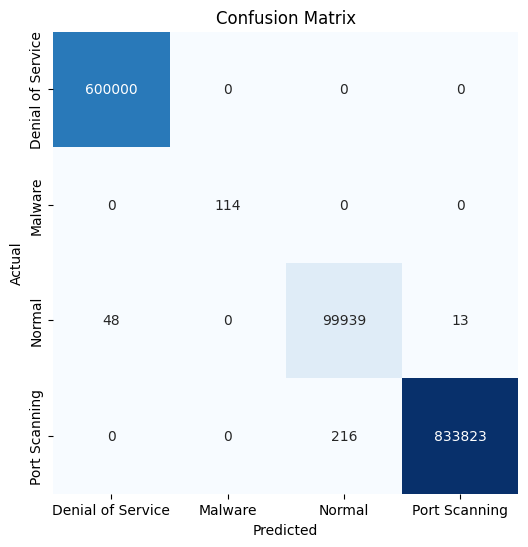

In [9]:

# Confusion matrix with string labels
conf_mat = confusion_matrix(y_test_labels, y_pred)

# Get unique class labels from y_test and y_pred_encoded
unique_labels = np.unique(np.concatenate(
    (y_test_labels, y_pred)))

# Plotting the Confusion Matrix with class labels
plt.figure(figsize=(6, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

/tmp/ipykernel_2505575/2712972451.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(sorted_importance.values()), y=list(


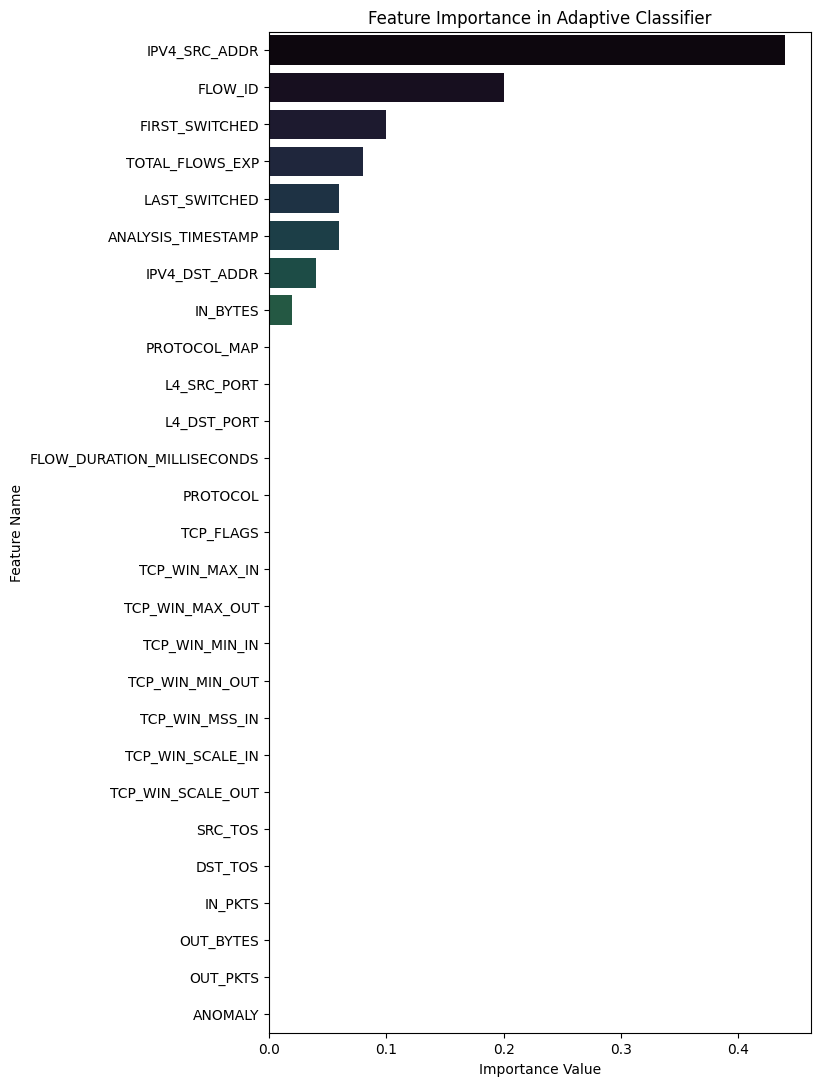

In [10]:
# importances of features in the decision tree model
importance = AdaB_model.feature_importances_
importance_dict = dict(zip(X.columns.values, importance))
sorted_importance = dict(
    sorted(importance_dict.items(), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(7, 13))
sns.barplot(x=list(sorted_importance.values()), y=list(
    sorted_importance.keys()), palette='cubehelix')
plt.xlabel('Importance Value')
plt.ylabel('Feature Name')
plt.title('Feature Importance in Adaptive Classifier')
plt.show()